## version
- python == 3.9.1
- pandas == '1.1.3'
- numpy == '1,19.2'
- matplotlib == '3.3.2'
- scikit-learn == '0.23.2'
- lightgbm == '3.1.1'
- pandas-summary==0.0.7

# [DACON] 시스템 품질 변화로 인한 사용자 불편 예지 AI 경진대회
# Team members : LearningHB, YOOYONG
# 2021년 02월 07일 (제출날짜) (Submission date)

# 1. 라이브러리 및 데이터

# Library & Data

In [5]:
import random
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import os
import datetime as dt
from tqdm import tqdm
tqdm.pandas()
import re
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_summary import DataFrameSummary


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

import warnings
warnings.filterwarnings(action='ignore')

#한글 폰트 사용
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['font.family'] = 'Malgun Gothic'


#data_path
train_path = 'LG_data/trainset'
test_path = 'LG_data/testset'

In [4]:
#data load

#err data
train_err  = pd.read_csv(train_path + '/train_err_data.csv')
test_err   = pd.read_csv(test_path  + '/test_err_data.csv')

#quality_data
train_quality = pd.read_csv(train_path + '/train_quality_data.csv')
test_quality  = pd.read_csv(test_path  + '/test_quality_data.csv')

#problem_data
train_problem  = pd.read_csv(train_path +'/train_problem_data.csv')


# 2. 데이터 전처리
# Data Cleansing & Pre-Processing

In [5]:
# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    mim  = int(x[10:12])
    sec  = int(x[12:])
    return dt.datetime(year, month, day, hour, mim, sec)

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)
    
# datetime  & days 컬럼 생성

def datetime_days_feature(df):
    df['datetime'] = df['time'].apply(make_datetime)
    min_day = df.datetime.min().date()
    df['days'] = df.loc[:,'datetime'].dt.date - min_day
    df['days'] = df['days'].dt.days
    
    return df

### problem

In [6]:
#y_labels 생성(y_train)
# person_idx의 problem이 한 번이라도 발생했다면 1, 없다면 0

problem = np.zeros(15000)
problem[train_problem.user_id.unique()-10000] = 1

train_problem.time =pd.to_datetime(train_problem.time.astype('str'))
p_user = train_problem.user_id.unique()                              #불만 제기 유저 list 저장
np_user = list(set(train_err.user_id.unique())  - set(p_user))  #불만 제기 X 유저 list 저장

train_problem_df = train_problem.user_id.value_counts().to_frame().reset_index()
train_problem_df.columns = ['user_id', 'count_e']

### err_data

In [7]:
#결측치 제거
train_err = train_err.dropna(axis=0)
test_err  = test_err.dropna(axis=0)

#중복 제거
train_err = train_err.drop_duplicates()
test_err  = test_err.drop_duplicates()

In [8]:
#datetime feature 생성
train_err =  datetime_days_feature(train_err)
test_err  =  datetime_days_feature(test_err)

#datetime feature -> dataframe 으로
train_err.datetime =  pd.to_datetime(train_err.datetime)
test_err.datetime  =  pd.to_datetime(test_err.datetime)

train_err = pd.merge(train_err,train_problem_df,on='user_id',how='outer')
train_err.count_e =train_err.count_e.fillna(0).astype('int')

#-------------------------------------------------------------------
#errcode labeling
total_errcode_df = pd.concat([train_err[['errcode']], test_err[['errcode']]], axis=0)
le = LabelEncoder()
le.fit(total_errcode_df.errcode)
train_err['errcode_label'] = le.transform(train_err['errcode'])
test_err['errcode_label']  = le.transform(test_err['errcode'])



In [9]:
del total_errcode_df

### quality_data

In [10]:
#datetime feature 생성
train_quality = datetime_days_feature(train_quality)
test_quality  = datetime_days_feature(test_quality)

#컬럼 순서 변경
train_quality = train_quality[['user_id','time', 'datetime','days','fwver',
                                         'quality_0','quality_1','quality_2','quality_3','quality_4','quality_5','quality_6',
                                         'quality_7','quality_8','quality_9','quality_10','quality_11','quality_12']]

test_quality = test_quality[['user_id','time', 'datetime','days','fwver',
                                         'quality_0','quality_1','quality_2','quality_3','quality_4','quality_5','quality_6',
                                         'quality_7','quality_8','quality_9','quality_10','quality_11','quality_12']]

#-----------------------------------------------------------------------------------
#quality_ 변수 수치형으로 변경

obj = train_quality.iloc[:,5:]
obj = obj.applymap(lambda x: str(x).replace(',',''))
obj = obj.astype('float32')
train_quality = pd.concat([train_quality.iloc[:,:5], obj], axis=1)

obj = test_quality.iloc[:,5:]
obj = obj.applymap(lambda x: str(x).replace(',',''))
obj = obj.astype('float32')
test_quality  = pd.concat([test_quality.iloc[:, :5], obj], axis=1)


tqq =train_quality[['time','user_id']].reset_index(drop=True)

tqq.time = pd.to_datetime(tqq.time.astype('str'))

# 3. 탐색적 자료분석
# Exploratory Data Analysis

In [275]:
#EDA 시각화 함수

def make_model_nm_eda(df):
    train_model_cnt = df.groupby(['model_nm']).count()['user_id'].reset_index()
    train_model_cnt.rename(columns = {'user_id' : 'count'}, inplace=True)
    train_model_cnt['per'] = train_model_cnt['count'] / len(df) * 100
    display(train_model_cnt)

    plt.title('model_nm별 분포', fontdict={'fontsize':15})
    plt.rcParams['font.family'] = 'Malgun Gothic'  #font 설정
    sns.barplot(x = train_model_cnt['model_nm'], y=train_model_cnt['count'], data=train_model_cnt)
    plt.show()
#     return train_model_cnt
    
def make_fwver_eda(df):
    train_fwver_cnt = df.groupby(['model_nm','fwver']).count().reset_index()[['model_nm', 'fwver', 'user_id']]
    train_fwver_cnt.rename({'user_id' : 'count'}, axis='columns', inplace=True)
    train_fwver_cnt['per'] = train_fwver_cnt['count']/len(df)*100
    train_fwver_cnt = train_fwver_cnt.sort_values(by='count', ascending=False)
    display(train_fwver_cnt.head(10))

    #상위 10개

    plt.figure(figsize=(12,6))
    plt.title('fwver별 분포', fontdict={'fontsize':15})
    plt.xticks(rotation = 90)
    plt.rcParams['font.family'] = 'Malgun Gothic'  #font 설정
    sns.barplot(x = train_fwver_cnt['fwver'],
                y=train_fwver_cnt['count'],
                data=train_fwver_cnt,
#                 hue='model_nm'
               )   
    plt.show()
#     return train_fwver_cnt
    
def make_errtype_eda(df):
    train_errtype_cnt = pd.DataFrame(df['errtype'].value_counts()).reset_index()
    train_errtype_cnt.rename({'index':'errtype','errtype':'count'}, axis='columns', inplace=True)
    train_errtype_cnt['per'] = train_errtype_cnt['count'] / len(df) * 100
    display(train_errtype_cnt.head(20))
    
    #시각화
    plt.figure(figsize=(12,8))
    plt.title('errtype별 분포', fontdict={'fontsize':15})
    # plt.xticks(rotation = 90)
    plt.rcParams['font.family'] = 'Malgun Gothic'  #font 설정
    sns.barplot(x = train_errtype_cnt['errtype'], y=train_errtype_cnt['count'], data=train_errtype_cnt)   
    plt.show()
    
#     return train_errtype_cnt
    
def make_errcode_eda(df):
    err_code_count = pd.DataFrame(df['errcode'].value_counts()[:100]).reset_index()
    err_code_count.rename({'index':'errcode', 'errcode':'count'}, axis='columns', inplace=True)
    err_code_count['per'] = err_code_count['count']/len(df)*100
    display(err_code_count.head(10))

    plt.figure(figsize=(12,8))
    plt.title('errcode별 분포', fontdict={'fontsize':15})
    plt.xticks(rotation = 90)
    plt.rcParams['font.family'] = 'Malgun Gothic'  #font 설정
    sns.barplot(x = err_code_count['errcode'], y=err_code_count['count'], data=err_code_count)   
    plt.show()
#     return err_code_count

,model_nm,fwver,count,per
9,model_1,04.16.3553,5145420,33.481388
4,model_0,04.22.1750,2748374,17.883744
17,model_2,04.33.1261,2375757,15.459115
23,model_3,05.15.2138,1841272,11.981207
5,model_0,04.22.1778,1243732,8.092998
16,model_2,04.33.1185,911660,5.932196
27,model_4,03.11.1167,845808,5.503696
11,model_1,04.16.3571,142173,0.925124
35,model_8,04.73.2237,31480,0.204841
33,model_7,05.66.3237,30062,0.195614


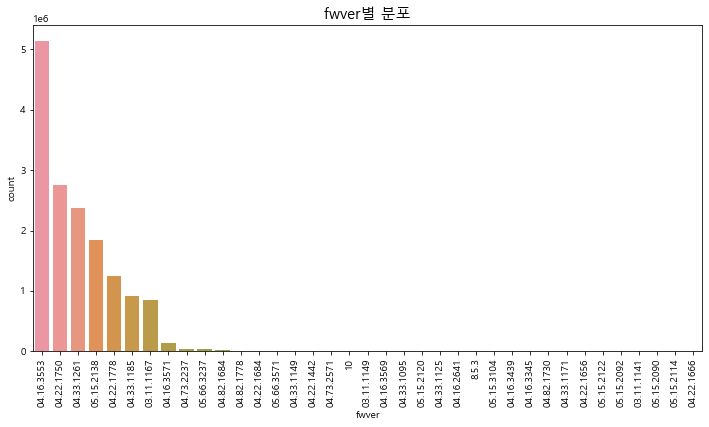

In [295]:
make_fwver_eda(train_err)

In [12]:
#err data 결측치, 빈도 수, 형식 확인

display(DataFrameSummary(train_err).columns_stats)
display(DataFrameSummary(test_err).columns_stats)

,user_id,time,model_nm,fwver,errtype,errcode,datetime,days,count_e,errcode_label
counts,15368001,15368001,15368001,15368001,15368001,15368001,15368001,15368001,15368001,15368001
uniques,15000,2566163,9,37,41,2805,2566163,33,6,2805
missing,0,0,0,0,0,0,0,0,0,0
missing_perc,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
types,numeric,numeric,categorical,categorical,numeric,categorical,date,numeric,numeric,numeric


,user_id,time,model_nm,fwver,errtype,errcode,datetime,days,errcode_label
counts,15527221,15527221,15527221,15527221,15527221,15527221,15527221,15527221,15527221
uniques,14998,2567716,9,40,41,2955,2567716,39,2955
missing,0,0,0,0,0,0,0,0,0
missing_perc,0%,0%,0%,0%,0%,0%,0%,0%,0%
types,numeric,numeric,categorical,categorical,numeric,categorical,date,numeric,numeric


#### fw_ver별 분포

,model_nm,fwver,count,per
9,model_1,04.16.3553,5145420,33.481388
4,model_0,04.22.1750,2748374,17.883744
17,model_2,04.33.1261,2375757,15.459115
23,model_3,05.15.2138,1841272,11.981207
5,model_0,04.22.1778,1243732,8.092998
16,model_2,04.33.1185,911660,5.932196
27,model_4,03.11.1167,845808,5.503696
11,model_1,04.16.3571,142173,0.925124
35,model_8,04.73.2237,31480,0.204841
33,model_7,05.66.3237,30062,0.195614


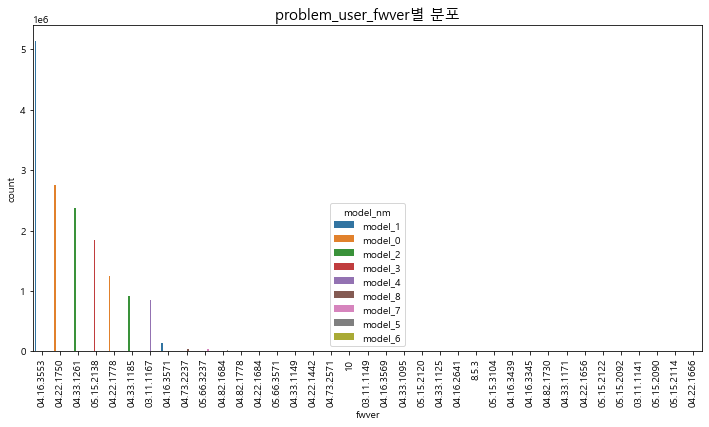

In [13]:
make_fwver_eda(train_err)

- model_nm(hue)별 fw_ver의 분포 확인
- 상위 7개의 model이 전체의 98%를 차지함
- model_1의 04.16.3553이 가장 많음
- model_0의 04.22.1750이 2번째로 많음

#### model_nm 분포

,model_nm,count,per
0,model_0,3999738,26.026404
1,model_1,5289106,34.416356
2,model_2,3291723,21.419331
3,model_3,1842206,11.987284
4,model_4,847124,5.512259
5,model_5,29553,0.192302
6,model_6,1708,0.011114
7,model_7,33241,0.216300
8,model_8,33602,0.218649


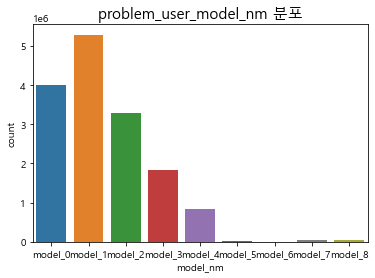

In [14]:
make_model_nm_eda(train_err)

In [15]:
# train_model_cnt['per'][:5].sum()

- model 0, 1, 2, 3, 4의 비율이 전체의 99.36%를 차지함

#### model_nm 5,6,7,8 vs model_nm_01234 비교

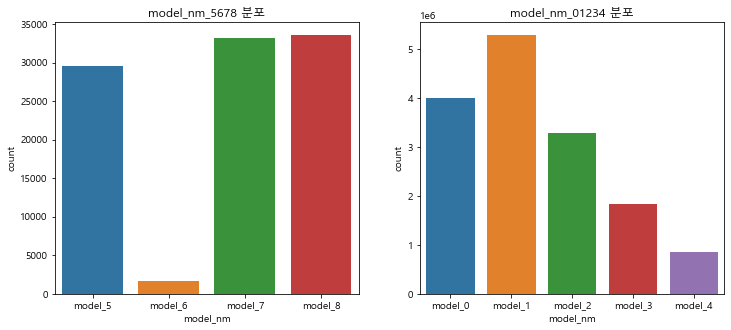

In [16]:
#model_5,6,7,8만 뽑기
train_model_5678 = train_err[(train_err['model_nm'] == 'model_5')|
                             (train_err['model_nm'] == 'model_6')|
                             (train_err['model_nm'] == 'model_7')|
                             (train_err['model_nm'] == 'model_8')]

#model_0,1,2,3,4만 뽑기
train_model_01234 = train_err[(train_err['model_nm'] == 'model_0')|
                              (train_err['model_nm'] == 'model_1')|
                              (train_err['model_nm'] == 'model_2')|
                              (train_err['model_nm'] == 'model_3')|
                              (train_err['model_nm'] == 'model_4')]

#model_5678 vs model_1234
#분포 비교
train_model_5678_cnt = train_model_5678.groupby(['model_nm']).count()['user_id'].reset_index()
train_model_5678_cnt.rename({'user_id':'count'}, axis='columns', inplace=True)
train_model_5678_cnt['per'] = train_model_5678_cnt['count'] / len(train_model_5678) * 100

train_model_01234_cnt = train_model_01234.groupby(['model_nm']).count()['user_id'].reset_index()
train_model_01234_cnt.rename({'user_id':'count'}, axis='columns', inplace=True)
train_model_01234_cnt['per'] = train_model_01234_cnt['count'] / len(train_model_01234) * 100


#분포 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'  #font 설정
f,axes = plt.subplots(1,2, figsize=(12,5), sharex=False)

#model_nm_5678
ax = sns.barplot(x = train_model_5678_cnt['model_nm'],
                 y=train_model_5678_cnt['count'],
                 data=train_model_5678_cnt,
                 ax=axes[0])
ax.set_title('model_nm_5678 분포', fontdict={'fontsize':12})

#model_nm_01234
bx = sns.barplot(x = train_model_01234_cnt['model_nm'],
                 y=train_model_01234_cnt['count'],
                 data=train_model_01234_cnt,
                 ax = axes[1])
bx.set_title('model_nm_01234 분포', fontdict={'fontsize':12})
plt.show()

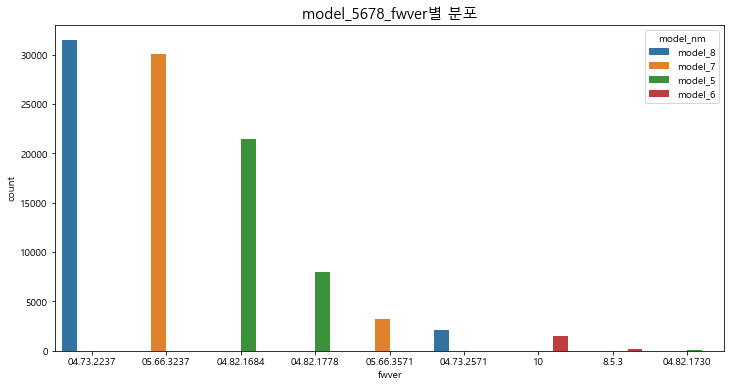

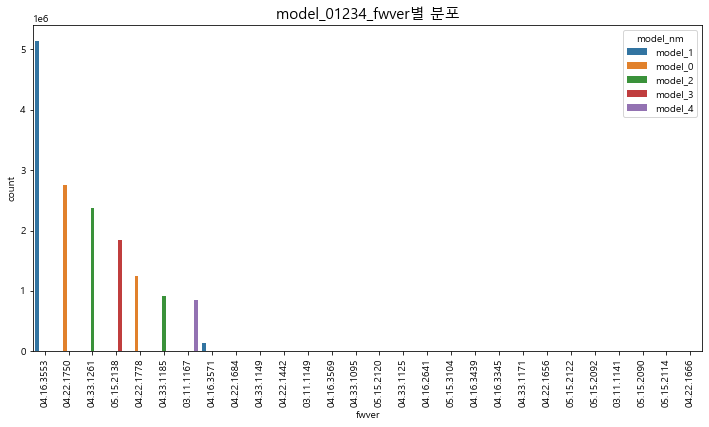

In [17]:
#model_5678별 fwver의 count
train_fwver_5678_cnt = train_model_5678.groupby(['model_nm','fwver']).count().reset_index()[['model_nm', 'fwver', 'user_id']]
train_fwver_5678_cnt.rename({'user_id' : 'count'}, axis='columns', inplace=True)
train_fwver_5678_cnt['per'] = train_fwver_5678_cnt['count']/len(train_model_5678)*100
train_fwver_5678_cnt = train_fwver_5678_cnt.sort_values(by='count', ascending=False)


plt.figure(figsize=(12,6))
plt.title('model_5678_fwver별 분포', fontdict={'fontsize':15})
# plt.xticks(rotation = )
plt.rcParams['font.family'] = 'Malgun Gothic'  #font 설정
sns.barplot(x =    train_fwver_5678_cnt['fwver'],
            y =    train_fwver_5678_cnt['count'],
            data = train_fwver_5678_cnt,
            hue =  'model_nm')   
plt.show()

#----------------------------------------------------------------------------

#model_01234별 fwver의 count
train_fwver_01234_cnt = train_model_01234.groupby(['model_nm','fwver']).count().reset_index()[['model_nm', 'fwver', 'user_id']]
train_fwver_01234_cnt.rename({'user_id' : 'count'}, axis='columns', inplace=True)
train_fwver_01234_cnt['per'] = train_fwver_01234_cnt['count']/len(train_model_01234)*100
train_fwver_01234_cnt = train_fwver_01234_cnt.sort_values(by='count', ascending=False)

plt.figure(figsize=(12,6))
plt.title('model_01234_fwver별 분포', fontdict={'fontsize':15})
plt.xticks(rotation = 90)
plt.rcParams['font.family'] = 'Malgun Gothic'  #font 설정
sns.barplot(x = train_fwver_01234_cnt['fwver'],
            y=train_fwver_01234_cnt['count'],
            data=train_fwver_01234_cnt,
            hue='model_nm')   
plt.show()

#### err_type별 분포

,errtype,count,per
0,23,2276011,14.810065
1,31,1985037,12.916690
2,22,1863495,12.125813
3,15,1562517,10.167341
4,4,1291986,8.406988
5,16,1248142,8.121694
6,32,1130247,7.354548
7,40,730283,4.751971
8,5,630279,4.101243
9,26,530998,3.455218


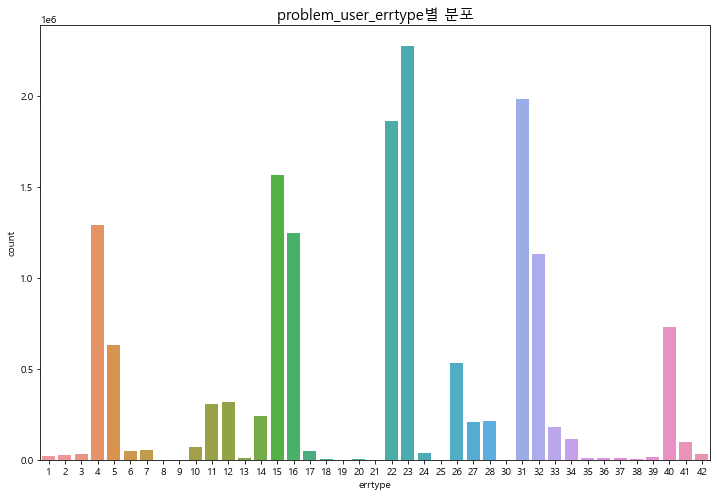

In [18]:
make_errtype_eda(train_err)

In [19]:
# train_errtype_cnt['per'][:20].sum()

- errtype_ 상위 20개가 전체 errtype의 약 98%를 차지함

#### errcode 별 분포

,errcode,count,per
0,1,8097696,52.691928
1,0,2594264,16.880946
2,connection timeout,1835262,11.942100
3,B-A8002,575827,3.746922
4,80,333929,2.172885
5,79,332356,2.162650
6,14,250982,1.633147
7,active,219195,1.426308
8,2,150920,0.982041
9,84,129829,0.844801


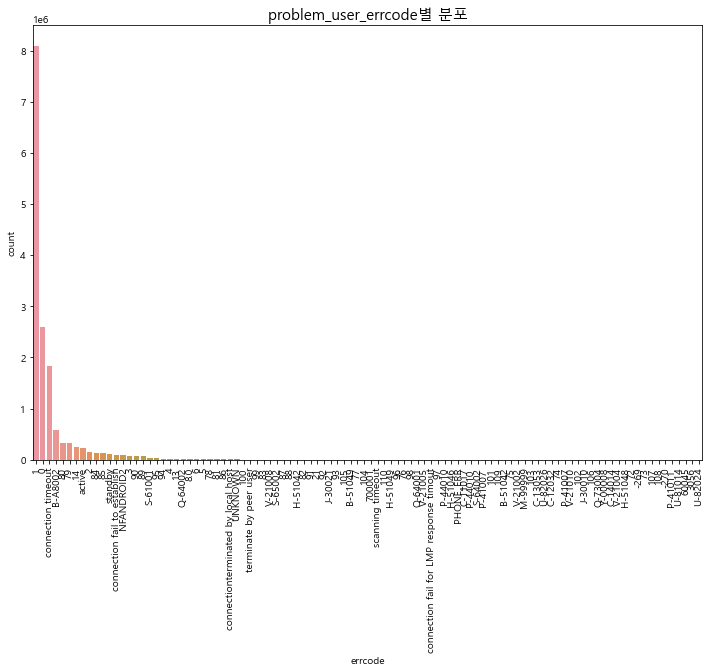

In [20]:
make_errcode_eda(train_err)

- '1', '0', 'connection timeout이 대부분을 차지함
- 'connection'이 자주 출몰하는것으로 보아 중요한 변수로 판단

In [21]:
# err_code_count['per'][:20].sum()

- errcode 상위 20개가 전체 errcode의 약 99.2%를 차지함 

## fwver

In [22]:
# train_quality.isnull().sum()
# fwver nan count : 40080
#quality_0 nan count : 144432 / quality_2 nan count  : 40113 / quality_5 nan count : 20

# fwver 가장 많은 빈도수로 채움 & quality_n 데이터는 앞의 데이터로 채움

train_fill_data = {'fwver' : train_quality.fwver.mode().iloc[0]}
train_quality = train_quality.fillna(train_fill_data)

test_fill_data = {'fwver' : test_quality.fwver.mode().iloc[0]}
test_quality = test_quality.fillna(test_fill_data)

train_quality = train_quality.fillna(method='pad')
test_quality  = test_quality.fillna(method='pad')

In [23]:
print('train_err의 fwver : ', len(train_err.fwver.unique()))
display(train_err.fwver.unique())

print('test_err의 fwver : ',  len(test_err.fwver.unique()))
display(test_err.fwver.unique())


err_diff_fwver_train = list(set(train_err.fwver.unique()) - set(test_err.fwver.unique()))  
err_diff_fwver_test = list(set(test_err.fwver.unique()) - set(train_err.fwver.unique())) 
print('train에만 있는 fwver:',err_diff_fwver_train)
print('test에만 있는 fwver :', err_diff_fwver_test)

train_err의 fwver :  37


array(['05.15.2138', '04.33.1185', '04.33.1261', '04.22.1750',
       '04.22.1778', '04.16.3553', '04.33.1149', '04.16.3571',
       '05.66.3237', '05.66.3571', '03.11.1149', '04.22.1684',
       '03.11.1167', '04.82.1684', '04.82.1778', '04.33.1171',
       '04.73.2237', '10', '04.82.1730', '04.73.2571', '8.5.3',
       '04.22.1666', '03.11.1141', '05.15.2120', '04.33.1125',
       '04.16.3439', '04.22.1442', '04.33.1095', '04.16.3569',
       '05.15.2090', '05.15.3104', '05.15.2122', '04.22.1656',
       '04.16.2641', '05.15.2114', '04.16.3345', '05.15.2092'],
      dtype=object)

test_err의 fwver :  40


array(['04.16.3553', '04.16.3571', '04.33.1261', '05.15.2138',
       '04.22.1750', '04.22.1778', '04.33.1149', '03.11.1167',
       '04.33.1185', '04.22.1684', '05.15.2120', '04.82.1684',
       '04.82.1778', '10', '05.66.3237', '04.73.2569', '04.73.2571',
       '04.73.2237', '04.73.2577', '04.82.1730', '04.22.1478', '8.5.3',
       '04.22.1666', '04.22.1656', '03.11.1149', '04.33.1171',
       '05.66.3571', '04.16.3439', '05.15.2092', '03.11.1141',
       '04.22.1608', '05.15.3104', '04.33.1125', '04.22.1448',
       '05.15.2114', '10.22.1770', '10.22.1780', '04.16.3569',
       '04.22.1772', '04.22.1170'], dtype=object)

train에만 있는 fwver: ['04.22.1442', '04.33.1095', '04.16.3345', '05.15.2122', '05.15.2090', '04.16.2641']
test에만 있는 fwver : ['04.22.1478', '10.22.1780', '04.22.1608', '04.73.2577', '10.22.1770', '04.22.1772', '04.22.1170', '04.73.2569', '04.22.1448']


In [24]:
# err data의 fwver 합집합
err_fwver = set(train_err.fwver.unique()).union(set(test_err.fwver.unique()))
print('err_data 전체 fwver 수:', len(err_fwver))
print(err_fwver)


err_data 전체 fwver 수: 46
{'04.22.1478', '04.22.1666', '04.33.1095', '05.15.3104', '05.15.2120', '04.22.1608', '04.82.1684', '04.22.1778', '04.22.1442', '03.11.1141', '04.22.1170', '04.33.1261', '04.16.3439', '10', '04.22.1684', '04.22.1656', '05.15.2114', '04.22.1772', '04.33.1171', '04.82.1778', '04.73.2569', '03.11.1149', '04.16.3571', '04.16.2641', '04.22.1448', '05.66.3237', '04.82.1730', '04.16.3553', '04.33.1149', '03.11.1167', '05.15.2090', '04.33.1185', '04.73.2571', '04.73.2237', '05.15.2092', '10.22.1780', '04.16.3569', '10.22.1770', '05.66.3571', '04.22.1750', '04.16.3345', '05.15.2122', '8.5.3', '05.15.2138', '04.73.2577', '04.33.1125'}


In [25]:
print('train_quality의 fwver : ', len(train_quality.fwver.unique()))
display(train_quality.fwver.unique())

print('test_quality의 fwver : ',  len(test_quality.fwver.unique()))
display(test_quality.fwver.unique())


quality_diff_fwver_train = list(set(train_quality.fwver.unique()) - set(test_quality.fwver.unique()))  
quality_diff_fwver_test = list(set(test_quality.fwver.unique()) - set(train_quality.fwver.unique())) 
print('train에만 있는 fwver:',quality_diff_fwver_train)
print('test에만 있는 fwver :', quality_diff_fwver_test)

train_quality의 fwver :  27


array(['05.15.2138', '04.22.1750', '04.16.3553', '04.33.1261',
       '04.22.1778', '04.33.1185', '04.16.3571', '05.66.3571',
       '03.11.1149', '03.11.1167', '04.82.1684', '04.82.1778',
       '04.33.1149', '05.66.3237', '04.73.2237', '09.17.1431',
       '04.22.1684', '05.15.2120', '04.33.1125', '05.15.2122',
       '04.22.1666', '04.22.1656', '04.16.3439', '04.73.2571',
       '05.15.2114', '04.16.3345', '04.22.1442'], dtype=object)

test_quality의 fwver :  22


array(['04.33.1261', '05.15.2138', '04.22.1750', '04.22.1778',
       '04.16.3553', '09.17.1431', '03.11.1167', '04.33.1149',
       '04.33.1185', '04.22.1684', '04.82.1684', '04.16.3571',
       '04.73.2571', '04.82.1778', '04.73.2237', '05.66.3237',
       '05.66.3571', '03.11.1149', '05.15.2120', '04.33.1125',
       '04.16.3439', '05.15.2114'], dtype=object)

train에만 있는 fwver: ['04.22.1666', '04.22.1442', '04.16.3345', '05.15.2122', '04.22.1656']
test에만 있는 fwver : []


In [26]:
print('err_data의 fwver : ', len(err_fwver))
display(err_fwver)

print('quality_data의 fwver : ',  len(train_quality.fwver.unique()))
display(train_quality.fwver.unique())


err_diff_fwver = list(err_fwver - set(train_quality.fwver.unique()))
quality_diff_fwver = list(set(train_quality.fwver.unique()) - err_fwver)

print('err_data에만 있는 fwver:',err_diff_fwver,'\n')
print('quality_data에만 있는 fwver :', quality_diff_fwver)

err_data의 fwver :  46


{'03.11.1141',
 '03.11.1149',
 '03.11.1167',
 '04.16.2641',
 '04.16.3345',
 '04.16.3439',
 '04.16.3553',
 '04.16.3569',
 '04.16.3571',
 '04.22.1170',
 '04.22.1442',
 '04.22.1448',
 '04.22.1478',
 '04.22.1608',
 '04.22.1656',
 '04.22.1666',
 '04.22.1684',
 '04.22.1750',
 '04.22.1772',
 '04.22.1778',
 '04.33.1095',
 '04.33.1125',
 '04.33.1149',
 '04.33.1171',
 '04.33.1185',
 '04.33.1261',
 '04.73.2237',
 '04.73.2569',
 '04.73.2571',
 '04.73.2577',
 '04.82.1684',
 '04.82.1730',
 '04.82.1778',
 '05.15.2090',
 '05.15.2092',
 '05.15.2114',
 '05.15.2120',
 '05.15.2122',
 '05.15.2138',
 '05.15.3104',
 '05.66.3237',
 '05.66.3571',
 '10',
 '10.22.1770',
 '10.22.1780',
 '8.5.3'}

quality_data의 fwver :  27


array(['05.15.2138', '04.22.1750', '04.16.3553', '04.33.1261',
       '04.22.1778', '04.33.1185', '04.16.3571', '05.66.3571',
       '03.11.1149', '03.11.1167', '04.82.1684', '04.82.1778',
       '04.33.1149', '05.66.3237', '04.73.2237', '09.17.1431',
       '04.22.1684', '05.15.2120', '04.33.1125', '05.15.2122',
       '04.22.1666', '04.22.1656', '04.16.3439', '04.73.2571',
       '05.15.2114', '04.16.3345', '04.22.1442'], dtype=object)

err_data에만 있는 fwver: ['04.22.1478', '04.33.1095', '04.82.1730', '05.15.2090', '05.15.3104', '04.22.1608', '03.11.1141', '04.22.1170', '05.15.2092', '10.22.1780', '04.16.3569', '10.22.1770', '10', '8.5.3', '04.73.2577', '04.22.1772', '04.33.1171', '04.73.2569', '04.22.1448', '04.16.2641'] 

quality_data에만 있는 fwver : ['09.17.1431']


- quality_data에만 있는 fwver : ['09.17.1431']


In [27]:
#전체 fwver
total_fwver = err_fwver.union(set(train_quality.fwver.unique()))
print('전체 fwver :', len(total_fwver))
print(total_fwver)

전체 fwver : 47
{'04.22.1478', '05.66.3237', '04.22.1666', '04.33.1095', '04.82.1730', '04.16.3553', '04.33.1149', '03.11.1167', '05.15.2090', '05.15.3104', '04.33.1185', '05.15.2120', '04.22.1608', '04.22.1448', '04.82.1684', '04.22.1778', '04.22.1442', '03.11.1141', '04.73.2571', '04.22.1170', '04.73.2237', '04.33.1261', '09.17.1431', '05.15.2092', '10.22.1780', '04.16.3569', '10.22.1770', '04.16.3439', '10', '05.66.3571', '04.22.1750', '04.16.3345', '04.22.1684', '05.15.2122', '04.33.1125', '8.5.3', '05.15.2138', '04.22.1656', '04.73.2577', '05.15.2114', '04.22.1772', '04.33.1171', '04.82.1778', '04.73.2569', '03.11.1149', '04.16.3571', '04.16.2641'}


- train_quality_data에 fwver 모두 존재

# 4. 변수 선택 및 모델 구축
# Feature Engineering & Modeling

- group1 : errcode 발생 count(error_code_df)
- group2 : 주 사용 fwver(fwver_onehot)
- group3 : quality_ratio_score(train_q0_to_12_df, test_q0_to_12_df)
- group4 : errcode 누적치(errcode_acc)
- group5 : errtype 비율(errtype_rate)
- group6 : err_data time 간격(date_step)
- group7 : quality_data time 간격 및 통계치(step_quality_step)
- group8 : 주 사용 모델(model_onehot)
- group9 : fwver_update
- group10 : model_update
- group11 : errcount mean & std
- group12 : fw_model_flow
- group13 : time_term
- group14 : connection err counts
- group15 : main_fw
- group16 : main_fw_err_counts

In [146]:
#making feature

#------------------------------------------------------------------------------------- errcode base
def errcode_make_vector(df, is_test = False):
    
    if is_test == False:
        zoro_0 = len(df['user_id'].value_counts())
    if is_test == True:
        zoro_0 = len(df['user_id'].value_counts())+1

    zero_1 = df['errcode_label'].max()
    person_min = df['user_id'].min()
  
    
    #errcode 벡터화
    id_errcode = df[['user_id', 'errcode_label']].values
    err_code = np.zeros((zoro_0,zero_1))

    for person_idx, err in tqdm(id_errcode):
        err_code[person_idx - person_min, err -1] += 1

    #dataframe으로
    error_code_df = pd.DataFrame(data=err_code)
    error_code_df.rename(columns = lambda x:"errcode_" + str(x), inplace=True)

    return error_code_df

def make_fwver_onehot(df, is_err = True):
    fwver_group = df.groupby(['user_id','fwver']).count().reset_index()[['user_id', 'fwver']]
    err_fwver_onehot = pd.get_dummies(fwver_group)
    err_fwver_onehot = err_fwver_onehot.groupby(['user_id']).sum().reset_index()

    cols = [c[6:] for c in err_fwver_onehot.columns if c[:5] == 'fwver']
    cols.insert(0, 'user_id')
    err_fwver_onehot.columns = cols
    
    if is_err:
        err_fwver_onehot = pd.merge(left=fwver_zeros_df, right=err_fwver_onehot, how='right').fillna(0)
        
    else:
        pass 
        
    return err_fwver_onehot


#------------------------------------------------------------------------------------- quality_ratio_score
#quality_ 종류의 user별 ratio 도출
def make_quality_df(df, n):
    quality_col = df.columns[5:][n]  

      #quality_col 에서 quality_n feature 선택
    
    q_cnt = df.groupby(['user_id', quality_col]).count()['time'].reset_index()
    q_cnt.rename(columns={quality_col:'q{}_value'.format(n),'time':'q{}_cnt'.format(n)}, inplace=True)

    #quality 내의 종류 별 비율 추가
     #quality 내 종류의 합 (q0_total_cnt)
    q_total_cnt = pd.DataFrame(q_cnt.groupby(['user_id']).sum()['q{}_cnt'.format(n)]).reset_index()
    q_total_cnt.rename(columns = {'q{}_cnt'.format(n) : 'q{}_total_cnt'.format(n)}, inplace=True)
    q_cnt = q_cnt.merge(q_total_cnt, on='user_id')

    #qo_per feature 추가
    q_cnt['q{}_per'.format(n)] = q_cnt['q{}_cnt'.format(n)] / q_cnt['q{}_total_cnt'.format(n)]
    #q_value * q_cnt *  q_per
    q_cnt['q{}_value'.format(n)+' * cnt * per'] = q_cnt['q{}_value'.format(n)]\
                                                  * q_cnt['q{}_cnt'.format(n)]\
                                                  * q_cnt['q{}_per'.format(n)]
    
    #quality_df
    #'q{}_cnt'.format(n)는 일단 제외
    quality_df = q_cnt.groupby(['user_id']).sum().reset_index()[['user_id',
                                                                'q{}_value'.format(n)+' * cnt * per']]
    
    quality_df.drop(['user_id'], axis =1 , inplace= True)
    
    return quality_df

def make_q0_to_q12(df, is_test = False):
    
    df_list = []
    for i  in range(0,13):
        if i in [3,4]:
            continue
        df_list.append(make_quality_df(df, i))
        
    q0_to_12_df = pd.concat(df_list, axis=1)
    q0_to_12_df['user_id'] = df.user_id.unique()
    
    if is_test:
        dummy = pd.DataFrame(data=[i for i in range(30000, 44999)], columns=['user_id'])

    else:
        dummy = pd.DataFrame(data=[i for i in range(10000, 25000)], columns=['user_id'])
    
    q0_to_12_df = pd.merge(dummy, q0_to_12_df, how='outer', on='user_id').fillna(0)
    q0_to_12_df.drop(['user_id'], axis=1, inplace=True)
    
    return q0_to_12_df

#------------------------------------------------------------------------------------- err 누적 발생
def errcode_acc_df(df, is_train=True):
    
    days_df = pd.DataFrame(np.zeros((15000,45)))
    days_df.columns = ['day_0','day_1','day_2','day_3','day_4','day_5','day_6','day_7','day_8','day_9','day_10',
                       'day_11','day_12','day_13','day_14','day_15','day_16','day_17','day_18','day_19','day_20',
                       'day_21','day_22','day_23','day_24','day_25','day_26','day_27','day_28','day_29','day_30',
                       'day_31','day_32','day_33', 'day_34','day_35','day_36','day_37','day_38','day_39','day_40',
                       'day_41','day_42', 'day_43','day_44']
    
    errcode_acc = df.groupby(['user_id','days']).count()['errcode_label'].reset_index(drop=False)
    errcode_acc.rename(columns = {'errcode_label' : 'errcode_cnt'}, inplace=True)
    #누적 cnt 컬럼 생성
    errcode_acc['errcode_acc_cnt'] = errcode_acc.groupby(['user_id']).cumsum()['errcode_cnt']

    errcode_acc_df = errcode_acc.pivot_table(values='errcode_acc_cnt', index=errcode_acc.user_id, columns='days', aggfunc='first').reset_index()
    errcode_acc_df = errcode_acc_df.iloc[:,1:]
    errcode_acc_df = errcode_acc_df.fillna(method='pad', axis=1).fillna(0)
    
    if is_train:
        errcode_acc_df.columns = ['day_0','day_1','day_2','day_3','day_4','day_5','day_6','day_7','day_8','day_9','day_10',
                           'day_11','day_12','day_13','day_14','day_15','day_16','day_17','day_18','day_19','day_20',
                           'day_21','day_22','day_23','day_24','day_25','day_26','day_27','day_28','day_29','day_30',
                           'day_31','day_32']
        
        errcode_acc_df = pd.merge(errcode_acc_df, days_df, how='left').fillna(method='pad', axis=1)
    
    else:
        errcode_acc_df.columns = ['day_0','day_1','day_2','day_3','day_4','day_5','day_6','day_7','day_8','day_9','day_10',
                                    'day_11', 'day_12','day_13','day_14','day_15','day_16','day_17','day_18','day_19','day_20',
                                    'day_21','day_22','day_23','day_24','day_25','day_26','day_27','day_28','day_29','day_30',
                                    'day_31','day_32','day_33', 'day_34','day_35','day_39','day_41','day_44']

        errcode_acc_df = pd.merge(errcode_acc_df, days_df, how='left')
        
        #컬럼 순서 재배열(day0~days44)
        errcode_acc_df = errcode_acc_df[['day_0','day_1','day_2','day_3','day_4','day_5','day_6','day_7','day_8','day_9','day_10',
                                             'day_11','day_12','day_13','day_14','day_15','day_16','day_17','day_18','day_19','day_20',
                                             'day_21','day_22','day_23','day_24','day_25','day_26','day_27','day_28','day_29','day_30',
                                             'day_31','day_32','day_33', 'day_34','day_35','day_36','day_37','day_38','day_39','day_40',
                                             'day_41','day_42', 'day_43','day_44']]
        errcode_acc_df = errcode_acc_df.fillna(method='pad', axis=1)

        #43262user 없으므로 한행씩 뒤로 미뤄야함
        errcode_acc_df.loc[14998] = np.nan  #마지막 행에 nan 데이터 추가

        front_test_errcode_acc = errcode_acc_df.loc[0:13261, 'day_0':'day_44']   #errcode 누적 데이터피처의 위치
        behind_test_errcode_acc = errcode_acc_df.loc[13262:,'day_0':'day_44'].shift(1).fillna(0)  #한칸씩 뒤로 미룸
        errcode_acc_df = pd.concat([front_test_errcode_acc,behind_test_errcode_acc], axis=0)   #미룬 데이터를 test_errcode_acc에 새롭게 저장
        
    return errcode_acc_df

#------------------------------------------------------------------------------------- errtype_rate
def make_errtype_rate(data, is_test = False):
    
    col_names= ['errtype_rate_{}'.format(i) for i in range(1,43) if i != 29]
    
    id_errtype = data[['user_id','errtype']]
    errtype_onehot = pd.get_dummies(id_errtype, columns=['errtype'])
    errtype_onehot = errtype_onehot.groupby(['user_id']).sum().reset_index()

    #유저별 총 에러 발생횟수 컬럼
    errtype_onehot['errtype_count'] = errtype_onehot.loc[:,'errtype_1':'errtype_42'].sum(axis = 1)

    #타입별 에러율 계산
    errtype_rate = errtype_onehot.loc[:,'errtype_1':'errtype_42'].divide(errtype_onehot.loc[:,'errtype_count'], axis = 0)
    errtype_rate.columns = col_names

    #errtype_count 추가
    errtype_rate['errtype_count'] =  errtype_onehot['errtype_count']
    
    if is_test:
        add = pd.DataFrame(np.zeros(len(errtype_rate.columns)).reshape(1,-1), columns=errtype_rate.columns ,index=[13262])
        errtype_rate = pd.concat([errtype_rate.iloc[:13262], add, errtype_rate.iloc[13262:]]).reset_index(drop=True)
    
    return errtype_rate

#------------------------------------------------------------------------------------- date_step & quality_step
def cal_min_max_mean_step(timelist):
    timelist.sort()  # 이용날짜 리스트를 정렬
    length = len(timelist)
    steplist = []

    if length == 1:  # 날짜가 한번만 찍혔을 경우
        return 0, 0, 0
    elif length == 2:  # 날짜가 두번 찍힌 경우
        delta = timelist[1] - timelist[0]
        seconds = delta.astype('timedelta64[s]')
        step = int(seconds / np.timedelta64(1, 's'))
        return step, step, step
    else:  # 날짜가 세번 이상 찍힌경우
        for i in range(length - 1, 0, -1):
            delta = timelist[i] - timelist[i - 1]
            seconds = delta.astype('timedelta64[s]')
            steplist.append(seconds / np.timedelta64(1, 's'))

        return min(steplist), max(steplist), round(sum(steplist) / length, 1)

def make_time_step(data, is_test=False):
    """
    Parameters
    ---------------------------------------
    data: DataFrame
    is_test: bool, default=False ,
            Set is_test False if input is test data
    ---------------------------------------

    Return
    ---------------------------------------
    type: DataFrame
    shape : (-1, 3)
    columns: dt_step_min, dt_step_max, dt_step_mean
    ---------------------------------------
    """
    dt_step_temp = pd.DataFrame(data.groupby(['user_id'])['datetime'].apply(lambda x: x.unique()))

    dt_step_temp['dt_step_min'], dt_step_temp['dt_step_max'], dt_step_temp['dt_step_mean'] = zip(
        *dt_step_temp['datetime'].progress_apply(lambda x: cal_min_max_mean_step(x)))
    dt_step_temp.drop(['datetime'], axis=1, inplace=True)
    dt_step_temp = dt_step_temp.reset_index(drop=True)

    if is_test:  # test_err인 경우 없는 인원에 대한 처리가 필요함.
        temp_add = pd.DataFrame({"dt_step_min": 0, "dt_step_max": 0, "dt_step_mean": 0}, index=[13262])
        test_dt_step = pd.concat([dt_step_temp.iloc[:13262], temp_add, dt_step_temp.iloc[13262:]]).reset_index(
            drop=True)
        return test_dt_step

    return dt_step_temp


def make_q_time_step(data, is_test=False):
    """
    Parameters
    ---------------------------------------
    data: DataFrame
    is_test: bool, default=False ,
            Set is_test False if input is test data
    ---------------------------------------

    Return
    ---------------------------------------
    type: DataFrame
    shape : (-1, 3)
    columns: q_dt_step_min, q_dt_step_max, q_dt_step_mean
    ---------------------------------------
    """
    q_dt_step_temp = pd.DataFrame(data.groupby(['user_id'])['time'].apply(lambda x: x.unique()))

    q_dt_step_temp['q_dt_step_min'], q_dt_step_temp['q_dt_step_max'], q_dt_step_temp['q_dt_step_mean'] = zip(
        *q_dt_step_temp['time'].progress_apply(lambda x: cal_min_max_mean_step(x)))
    q_dt_step_temp.drop(['time'], axis=1, inplace=True)
    q_dt_step_temp = q_dt_step_temp.reset_index(drop=False)  # 얘는 dataframe, user_id컬럼이 있음.

    # 더미를 만들어야 함.
    if is_test:
        dummy = pd.DataFrame(data=[i for i in range(30000, 44999)], columns=['user_id'])

    else:
        dummy = pd.DataFrame(data=[i for i in range(10000, 25000)], columns=['user_id'])

    q_dt_step_temp = pd.merge(dummy, q_dt_step_temp, how='outer', on='user_id').fillna(0)
    q_dt_step_temp.drop(['user_id'], axis=1, inplace=True)

    return q_dt_step_temp


def make_q_statistics(data, is_test=False):
    """
    Parameters
    ---------------------------------------
    data: DataFrame
    is_test: bool, default=False ,
            Set is_test False if input is test data
    ---------------------------------------

    Return
    ---------------------------------------
    type: DataFrame
    shape : (-1, 55)            
    ---------------------------------------
    """

    df = data.copy()
    # 전부 0인 컬럼 제거
    df.drop(['quality_3', 'quality_4'], axis=1, inplace=True)
    # 결측치 처리
    df.loc[:, 'quality_0':'quality_12'] = df.loc[:, 'quality_0':'quality_12'].fillna(
        df.loc[:, 'quality_0':'quality_12'].median())

    q_cols = ['quality_{}'.format(i) for i in range(0, 13) if i not in [3, 4]]
    temp_col_mean = ['quality_{}_mean'.format(i) for i in range(0, 13) if i not in [3, 4]]
    temp_col_sum = ['quality_{}_sum'.format(i) for i in range(0, 13) if i not in [3, 4]]
    temp_col_median = ['quality_{}_median'.format(i) for i in range(0, 13) if i not in [3, 4]]
    temp_col_min = ['quality_{}_min'.format(i) for i in range(0, 13) if i not in [3, 4]]
    temp_col_max = ['quality_{}_max'.format(i) for i in range(0, 13) if i not in [3, 4]]

    q_statistics = pd.DataFrame(df['user_id'].unique(), columns=['user_id'])
    q_statistics[temp_col_mean] = df.groupby(['user_id'])[q_cols].mean().values
    q_statistics[temp_col_sum] = df.groupby(['user_id'])[q_cols].sum().values
    q_statistics[temp_col_median] = df.groupby(['user_id'])[q_cols].median().values
    q_statistics[temp_col_min] = df.groupby(['user_id'])[q_cols].min().values
    q_statistics[temp_col_max] = df.groupby(['user_id'])[q_cols].max().values

    q_statistics = q_statistics.round(3)

    if is_test:
        dummy = pd.DataFrame(data=[i for i in range(30000, 44999)], columns=['user_id'])

    else:
        dummy = pd.DataFrame(data=[i for i in range(10000, 25000)], columns=['user_id'])

    q_statistics = dummy.join(q_statistics.set_index('user_id'), on='user_id').fillna(0)
    q_statistics.drop(['user_id'], axis=1, inplace=True)

    return q_statistics
#------------------------------------------------------------------------------------- 주 사용 model_nm
def make_model_onehot(df, is_err = True):
    model_count = df.groupby(['user_id', 'model_nm']).count()['errtype'].reset_index()
    model_count.rename({'errtype':'model_nm_count'}, axis='columns')
    model_count = pd.DataFrame(model_count.groupby(['user_id']).max()['model_nm']).reset_index()
    model_count = pd.get_dummies(model_count['model_nm'])

    if is_err:  #train
        pass
    
    else:      #test
        #43262user 없으므로 한행씩 뒤로 미뤄야함
        model_count.loc[14998] = np.nan  #마지막 행에 nan 데이터 추가

        front_model_count = model_count.loc[0:13261, 'model_0':'model_8']   #errcode 누적 데이터피처의 위치
        behind_model_count = model_count.loc[13262:,'model_0':'model_8'].shift(1).fillna(0)  #한칸씩 뒤로 미룸
        model_count = pd.concat([front_model_count,behind_model_count], axis=0)   #미룬 데이터를 test_errcode_acc에 새롭게 저장
        
    return model_count



#------------------------------------------------------------------------------------- concat

def concat_df(problem_df, *args, not_test=True):
    total_df = pd.concat([i for i in args], axis=1, ignore_index=False)
    
    if not_test:
        
        #problem 데이터
        problem = np.zeros(15000)
        problem[problem_df.user_id.unique()-10000] = 1 

        #type_code_df + problem => 학습데이터
        total_df['problem'] = problem
        
    else:
        pass

    
    return total_df


### DACON 코드공유에서 datamanim님이 공유해주신 파생 feature 함수 추가

In [250]:
# 코드출처: https://dacon.io/competitions/official/235687/codeshare/2356?page=1&dtype=recent&ptype=pub

def check_unique(col,df1,df2):
    def change_len(x):
        if len(x) ==10:
            return x[:5]
        else:
            return x
#     print("about",col)
    if col !='fwvers':
        train_c = set(df1[col].unique())
        test_c  = set(df2[col].unique())
#         print("train only in %s "%col,train_c-test_c)
#         print("test only in %s "%col,test_c -train_c)
        total = (train_c | test_c)
    else:
        train_c = set(df1[col].apply(change_len).unique())
        test_c  = set(df2[col].apply(change_len).unique())
#         print("train only in %s "%col,train_c-test_c)
#         print("test only in %s "%col,test_c -train_c)
        total = (train_c | test_c)        
        
#     print()
        
    return total

model_total=check_unique('model_nm',train_err, test_err)
errtype_total=check_unique('errtype',train_err,test_err)
fwver_total = check_unique('fwver',train_err,test_err)

    #----------------------------------------------

def dataset_trans(df,types,Num_df_user,Num_errtype,First_index):
    
    
    num_df_user = Num_df_user
    num_errtype =Num_errtype
    first_index = First_index
    num_model_change =2

    
    #----------------------------------------------errtype
    errtypes = np.zeros((num_df_user,num_errtype))
    err = df[['user_id','errtype']].values

    for inx, value in tqdm(err):
        errtypes[inx-first_index,value-1] +=1


    # ---------------------------------------------model_change
    v=df[['user_id','model_nm']]
    getdf =~(v == v.shift(1))
    logical =(getdf.user_id.apply(int) + getdf.model_nm.apply(int)) > 0
    df_model_counts =v[logical]


    def get_model_change_id(num):
        df_mc = df_model_counts.user_id.value_counts()
        df_mc_user=list(df_mc.loc[df_mc ==num].to_frame().index)
        sort_mc_user = df.loc[df.user_id.isin(df_mc_user)].drop_duplicates(['user_id','model_nm'],keep='last').drop_duplicates('user_id',keep='first').sort_values("datetime").user_id
        return sort_mc_user.values

    one_m = get_model_change_id(1)
    two_m = get_model_change_id(2)
    thr_m = get_model_change_id(3)


    model_n = np.zeros((num_df_user,num_model_change))
    df['model_f'] =df['model_nm'].str[-1].astype('int')
    one_df = df.loc[df.user_id.isin(one_m)][['user_id','model_f']].drop_duplicates().values
    two_df =df.loc[df.user_id.isin(two_m)][['user_id','model_f']].drop_duplicates().reset_index(drop=True)
    two_df['tf'] = two_df.index%2
    two_df= two_df.pivot(index='user_id',columns='tf').reset_index().values
    thr_df = df.loc[df.user_id.isin(thr_m)][['user_id','model_f']].drop_duplicates().values

    for inx, value in tqdm(one_df):
        model_n[inx-first_index,0]  +=value
    for inx, value1,value2 in tqdm(two_df):
        model_n[inx-first_index,0]  +=value1
        model_n[inx-first_index,1]  +=value2

    for inx, value in tqdm(thr_df):
        model_n[inx-first_index,0]  +=value


    # ---------------------------------------------fw change
    fwver_total_dic ={}
    for v in range(len(fwver_total)):
        fwver_total_dic[sorted(list(fwver_total))[v]] = v+1

    def fwver_tran(x):
        return fwver_total_dic[x]


    df['ver_num'] = df['fwver'].apply(fwver_tran)
    fwver_np = np.zeros((num_df_user,5))

    v3=df[['user_id','ver_num']]
    getdf =~(v3 == v3.shift(1))
    logical =(getdf.user_id.apply(int) + getdf.ver_num.apply(int)) > 0
    fwver_num=v3[logical]

    fwver_num = fwver_num.reset_index(drop=True)
    count =np.zeros(len(fwver_num),dtype=int)

    for v in range(1,len(fwver_num)):
        if fwver_num.user_id.values[v-1] ==fwver_num.user_id.values[v]:
            count[v] = count[v-1] +1


    fwver_num['count'] =count
    fw_v = fwver_num.loc[fwver_num['count'].isin([0,1,2,3,4])].pivot(index='user_id',columns='count').reset_index().fillna(0).values
    fw_v =fw_v.astype('int64')

    
    
    
    for inx, v1,v2,v3,v4,v5 in tqdm(fw_v):
        fwver_np[inx-first_index,0] =v1
        fwver_np[inx-first_index,1] =v2
        fwver_np[inx-first_index,2] =v3
        fwver_np[inx-first_index,3] =v4
        fwver_np[inx-first_index,4] =v5

    #---------------------------------------------------------- errtype_ mean_std
    df['week'] =df.datetime.dt.isocalendar().week

    df = df.loc[(df.datetime >=pd.to_datetime('2020-11-01 00:00:00')) & (df.datetime<=pd.to_datetime('2020-11-30 23:59:59'))]
    datas = df[['user_id','errtype','week']]
    df_=datas[['user_id','week','errtype']].value_counts().to_frame().reset_index()
    df_ =df_.sort_values(['user_id','week']).rename(columns = {0:'counts'}).reset_index(drop=True)

    df1 =df_.loc[df_.week ==44][['user_id','errtype','counts']].values
    df2 =df_.loc[df_.week ==45][['user_id','errtype','counts']].values
    df3 =df_.loc[df_.week ==46][['user_id','errtype','counts']].values
    df4 =df_.loc[df_.week ==47][['user_id','errtype','counts']].values
    df5 =df_.loc[df_.week ==48][['user_id','errtype','counts']].values

    day_data = np.zeros((num_df_user,42,5))
    for i, dfa in enumerate([df1,df2,df3,df4,df5]):
        for inx , val1 ,val2 in tqdm(dfa):
            day_data[:,:,i][inx-first_index,val1-1] = val2

    m=day_data.mean(axis=2)
    std=day_data.std(axis=2)       
          
    #----------------------------------------------------------- errtype_ mean_std _of hour

    df['hour'] =df.datetime.dt.hour


    df = df.loc[(df.datetime >=pd.to_datetime('2020-11-01 00:00:00')) & (df.datetime<=pd.to_datetime('2020-11-30 23:59:59'))]

    datas = df[['user_id','errtype','hour']]
    df_=datas[['user_id','hour','errtype']].value_counts().to_frame().reset_index()
    df_ =df_.sort_values(['user_id','hour']).rename(columns = {0:'counts'}).reset_index(drop=True)


    day_data = np.zeros((num_df_user,42,24))
    for i in range(24):
        dfa = df_.loc[df_['hour']==i][['user_id','errtype','counts']].values
        for inx , val1 ,val2 in tqdm(dfa):
            day_data[:,:,i][inx-first_index,val1-1] = val2

    m2=day_data.mean(axis=2)
    std2=day_data.std(axis=2)       

    m2_1=day_data.max(axis=2)
    #----------------------------------------------------------- errtype_ mean_std _of day

    df['day'] =df.datetime.dt.day


    df = df.loc[(df.datetime >=pd.to_datetime('2020-11-01 00:00:00')) & (df.datetime<=pd.to_datetime('2020-11-30 23:59:59'))]
    datas = df[['user_id','errtype','day']]
    df_=datas[['user_id','day','errtype']].value_counts().to_frame().reset_index()
    df_ =df_.sort_values(['user_id','day']).rename(columns = {0:'counts'}).reset_index(drop=True)


    day_data = np.zeros((num_df_user,42,30))
    for i in range(30):
        dfa = df_.loc[df_['day']==(i+1)][['user_id','errtype','counts']].values
        for inx , val1 ,val2 in tqdm(dfa):
            day_data[:,:,i][inx-first_index,val1-1] = val2

    m3=day_data.mean(axis=2)
    std3=day_data.std(axis=2)       

    m3_1=day_data.max(axis=2) 
    
    
    
    
    
    #------------------------------------------------------------- fwver flow
    target_df = df
    first_num = first_index
    count_num =num_df_user

    dp = target_df[['user_id','model_nm','fwver']]
    unique_data =target_df[(dp !=dp.shift(1)).sum(axis=1)>0]

    dp2 = target_df[['user_id','model_nm']]
    unique_data2 =target_df[(dp2 !=dp2.shift(1)).sum(axis=1)>0]

    fwver_total_dic ={}
    for v in range(len(fwver_total)):
        fwver_total_dic[sorted(list(fwver_total))[v]] = v+1
    


    def fwver_tran(x):
        return fwver_total_dic[x]

    fwver = np.zeros((count_num,24))
    for idx in tqdm(unique_data.user_id.unique()):
        df_md =unique_data2.loc[unique_data2.user_id==idx].model_nm.values
        df_fw = unique_data.loc[unique_data.user_id==idx].fwver.values

        for md in range(len(df_md)):
            fwver[idx-first_num,md] = int(df_md[md][-1])+1

        for l in range(3,len(df_fw)+3):
            fwver[idx-first_num,l] =fwver_total_dic[df_fw[l-3]]

    fw_df = pd.DataFrame(fwver).reset_index().rename(columns={'index':'user_id'})

    fwver_total_dic_rev = {v: k for k, v in fwver_total_dic.items()}
    fwver_total_dic_rev2 = fwver_total_dic_rev.copy()
    fwver_total_dic_rev[0] =0
    fwver_total_dic_rev2[0] = '04.22.1750'  #max 값


    def fwver_tras_reverse(x):
        return fwver_total_dic_rev[x]

    def fwver_tras_reverse2(x):
        return fwver_total_dic_rev2[x]

    fw_df[3] =fw_df[3].apply(fwver_tras_reverse2)
    fw_df[4] =fw_df[4].apply(fwver_tras_reverse)
    fw_df[5] =fw_df[5].apply(fwver_tras_reverse)
    fw_df[6] =fw_df[6].apply(fwver_tras_reverse)
    fw_df[7] =fw_df[7].apply(fwver_tras_reverse)


    fw_df = fw_df.rename(columns={0:'md1',1:'md2',2:'md3',3:'fw1',4:'fw2',5:'fw3',6:'fw4',7:'fw5'})
    fw_df['user_id'] =fw_df['user_id']+10000

    pre_df=fw_df.iloc[:,:9]

    md_flow = {str(x.astype("int")):(i+1) for i,x in enumerate(pre_df[['md1','md2','md3']].drop_duplicates().reset_index(drop=True).values)}
    fw_flow = {str(x):(i+1) for i,x in enumerate(pre_df[['fw1','fw2','fw3','fw4','fw5']].drop_duplicates().reset_index(drop=True).values)}

    def fw_change_counter(x):
        fwlst = []
        for v in ['fw1','fw2','fw3','fw4','fw5']:
            if x[v] ==0:
                pass
            else:
                fwlst +=[x[v]]

        if len(fwlst) ==len(list(set(fwlst))):
            return 0
        else:
            return 1

    def check_problem(x):
        if x in p_user:
            return 1
        else:
            return 0

    def md_flow_change(x):
        return md_flow[str(x[['md1','md2','md3']].values.astype("int"))]

    def fw_flow_change(x):
        return fw_flow[str(x[['fw1','fw2','fw3','fw4','fw5']].values)]

    def mean_str_fw_dum(x):
        fwlst = []
        for v in ['fw1','fw2','fw3','fw4','fw5']:
            if x[v] ==0:
                pass
            else:
                fwlst +=[int(x[v].replace('.',""))]
        return np.array(fwlst).mean()



    def std_str_fw_dum(x):
        fwlst = []
        for v in ['fw1','fw2','fw3','fw4','fw5']:
            if x[v] ==0:
                pass
            else:
                fwlst +=[int(x[v].replace('.',""))]
        return np.array(fwlst).std()

    pre_df=fw_df.iloc[:,:9]
    pre_df['md_counts'] = pre_df[['md1','md2','md3']].astype('bool').sum(axis=1)
    pre_df['fw_counts'] = pre_df[['fw1','fw2','fw3','fw4','fw5']].astype('bool').sum(axis=1)

    pre_df['fw_change'] = pre_df.apply(fw_change_counter,axis=1)
    pre_df['fw_flows'] = pre_df.apply(fw_flow_change,axis=1)
    pre_df['md_flows'] = pre_df.apply(md_flow_change,axis=1)
    pre_df['fw_mean'] = pre_df.apply(mean_str_fw_dum,axis=1)
    pre_df['fw_std'] = pre_df.apply(std_str_fw_dum,axis=1)


    fw_model_flow =pre_df.iloc[:,9:].values    


    #------------------------------------------------------------------time term
    first_num = first_index
    count_num =num_df_user
    
    time_term = np.zeros((count_num,4))
    tre_t =df[['user_id','datetime']].drop_duplicates()

    for v in tqdm(tre_t.user_id.unique()):
        test =tre_t.loc[tre_t.user_id ==v].datetime
        if len(test) <=2:
            time_term[v-first_num,0] = 0
            time_term[v-first_num,1] = 0
            time_term[v-first_num,2] = test.values[-1]-test.values[0]
            time_term[v-first_num,3] = len(test)
        else:
            time_term[v-first_num,0] = (test -test.shift(1)).max().total_seconds()
            time_term[v-first_num,1] = (test -test.shift(1)).min().total_seconds()
            time_term[v-first_num,2] = test.values[-1]-test.values[0]  
            time_term[v-first_num,3] = len(test)

    dft = pd.DataFrame(time_term).copy()

    dft[0] =dft[0]/3600
    dft[2] =dft[2]/3600/24/10e8
    dft[2] =np.where(dft[2].values==0,1,dft[2].values)
    dft[5] =dft[0]/dft[3]
    dft[5] = dft[0]/dft[3]*3600
    dft[6] = dft[0]/24/dft[2]
    time_term = dft.fillna(0).values

    #------------------------------------------------------------------- connetion err
    err_df =df[['user_id','datetime','errcode']].dropna(axis=0)

    df_con =err_df.loc[err_df.errcode.str.contains("connection")]
    df_con['check_time'] = df_con.datetime.dt.date
    df_con['check_hour'] =df_con.datetime.dt.hour

    def connetion_df(con_df):
        day_con_err =con_df[['user_id','check_time']].value_counts().groupby("user_id").max()
        hour_con_err=con_df.groupby(['user_id','check_time','check_hour']).size().groupby("user_id").max()
        tenmin_con_err =con_df.set_index('datetime').groupby(['user_id','errcode']).resample("10min").size().groupby("user_id").max()
        con_trans =pd.concat([day_con_err,hour_con_err,tenmin_con_err],axis=1)
        return con_trans

    total_conn_err=[connetion_df(df_con)]
    for errs in tqdm(['connection timeout', 'connection fail to establish','connectionterminated by local host','connection fail for LMP response timout','L2CAP connection cancelled']):
        con_esta = df_con.loc[df_con.errcode.str.contains(errs)]
        total_conn_err.append(connetion_df(con_esta))

    base_df =pd.DataFrame(range(first_num,first_num+count_num)).rename(columns={0:'user_id'}).set_index('user_id')

    connetion_err_pre = pd.concat(total_conn_err+[base_df],axis=1).fillna(0).values
    
    
    
    
    
    #---------------------------------------------------------------------  main_fwver

    
    
    tsed = df.dropna(axis=0).reset_index(drop=True)[['user_id','datetime','fwver']]
    dfw = tsed[['user_id','fwver']]
    fw_d =dfw.loc[(dfw !=dfw.shift(1)).sum(axis=1)>0]

    main_fw_ar = np.zeros((num_df_user,6))
    for i,tgid in enumerate(tqdm(range(first_index,first_index+num_df_user))):

        tgdf =fw_d.loc[fw_d.user_id ==tgid].iloc[1:,:]
        tgidtotal = tsed.loc[tsed.user_id ==tgid]
        try:
            data =tgidtotal.loc[sorted([tgidtotal.index[0]] + [x-1 for x in tgdf.index]+[x for x in tgdf.index] + [tgidtotal.index[-1]] )]
            t1 =data.datetime
            if len(t1) %2 !=0:
                print('lenth error')
            time_delta = (t1-t1.shift(1)).dt.total_seconds()

            main_fwver =data.loc[time_delta.loc[time_delta==time_delta.max()].index].fwver.values[0]
            main_fw_ar[i,0] = fwver_total_dic[main_fwver]
            main_fw_ar[i,1] =(time_delta[1::2].values).max().astype('float')/(time_delta.values[1:]).sum().astype('float')  #target fw workingtime / total
            if len(time_delta) ==1:
                main_fw_ar[i,2] =0  #min of change fwver time==0
                main_fw_ar[i,3] =0  #std of change fwver time ==0
                main_fw_ar[i,4] =0  #std
                main_fw_ar[i,5] =0  #variance
            else:
                main_fw_ar[i,2] =time_delta[::2].min()/3600 # min hours
                main_fw_ar[i,3] =time_delta[::2].std()/3600
                main_fw_ar[i,4] =time_delta[1::2].values.astype('float').std()/3600  #std running time of fw
                main_fw_ar[i,5] =(time_delta[1::2].values.astype('float')/3600).var()  #std running time of fw
        except:
            main_fw_ar[i,0] =0
            main_fw_ar[i,1] =0
            main_fw_ar[i,2] =0
            main_fw_ar[i,3] =0
            main_fw_ar[i,4] =0
            main_fw_ar[i,5] =0

            
            
            
    #---------------------------------------------------------------------         

 

#     tred = df.dropna(axis=0).reset_index(drop=True)[['user_id','datetime','fwver']]
#     tred_all = df.dropna(axis=0).reset_index(drop=True)

#     main_fw_err_counts = np.zeros((num_df_user,84))
#     for i,tgid in enumerate(tqdm(range(first_index,num_df_user+first_index))):

#         tgdf =fw_d.loc[fw_d.user_id ==tgid].iloc[1:,:]
#         tgidtotal = tred_all.loc[tred_all.user_id ==tgid]
        
#         try:
#             data =tgidtotal.loc[sorted([tgidtotal.index[0]] + [x-1 for x in tgdf.index]+[x for x in tgdf.index] + [tgidtotal.index[-1]] )]
#             t1 =data.time
#             if len(t1) %2 !=0:
#                 print('lenth error')
#             time_delta = (t1-t1.shift(1)).dt.total_seconds()

#             main_fwver =data.loc[time_delta.loc[time_delta==time_delta.max()].index].fwver.values[0]


#             main_date = tgidtotal.loc[tgidtotal.fwver ==main_fwver][['datetime','errtype']]
#             main_date['date'] =main_date.datetime.dt.date
#             main_time_del  =(main_date.datetime.dt.date.values[-1] -main_date.datetime.dt.date.values[0]).days
#             date_first= main_date.datetime.dt.date.values[0]
#             err_count_main = np.zeros((42,main_time_del+1))
#             for n in  range(main_time_del+1):
#                 lcdf = main_date.loc[main_date.date ==date_first]
#                 for errtype in lcdf.errtype.values:
#                     err_count_main[errtype-1,n] +=1
#                 date_first += dt.timedelta(days=1)

#             main_fw_err_counts[i,:42] =     err_count_main.mean(axis=1)
#             main_fw_err_counts[i,42:] =     err_count_main.std(axis=1)

#         except:
#             main_fw_err_counts[i,:] = 0 


    #train data의 경우 label 까지 출력
    if types == 'train':
        def tf(x):
            if x>=1:
                return 1
            else:
                return 0
        df['tf'] =df.count_e.apply(tf)
        label=df[['user_id','tf']].drop_duplicates().values[:,1].reshape(-1,1)
        return [fwver_np,model_n, errtypes, m, std ,m2,std2,m2_1,m3,m3_1,std3,fw_model_flow , time_term ,connetion_err_pre  ,main_fw_ar,label]

    else:
        return [fwver_np,model_n, errtypes, m ,std ,m2,std2,m2_1,m3,m3_1,std3,fw_model_flow  ,time_term  ,connetion_err_pre  ,main_fw_ar  ]


about model_nm
train only in model_nm  set()
test only in model_nm  set()

about errtype
train only in errtype  set()
test only in errtype  set()

about fwver
train only in fwver  {'04.22.1442', '04.33.1095', '04.16.3345', '05.15.2122', '05.15.2090', '04.16.2641'}
test only in fwver  {'04.22.1478', '10.22.1780', '04.22.1608', '04.73.2577', '10.22.1770', '04.22.1772', '04.22.1170', '04.73.2569', '04.22.1448'}



### feature 생성

In [167]:
#-----------------------------------------------------------------------------  errcode base
train_error_code_df = errcode_make_vector(train_err, is_test= False)
test_error_code_df  = errcode_make_vector(test_err,  is_test=True)
#----------------------------------------------------------------------------- Using fwver
fwver_zeros_df = pd.DataFrame(np.zeros((15000,47)), columns = total_fwver).reset_index()
fwver_zeros_df.rename(columns={'index':'user_id'}, inplace=True)

train_err_fwver_onehot = make_fwver_onehot(train_err)
test_err_fwver_onehot  = make_fwver_onehot(test_err)
train_quality_fwver_onehot = make_fwver_onehot(train_quality, is_err = False)
test_quality_fwver_onehot  = make_fwver_onehot(test_quality, is_err = False)

#err 에는 '09.17.1431'없으므로 기존의 '09.17.1431'는 제거하고 quality_fwver에서 가져옴
train_err_fwver_onehot.drop(['09.17.1431'], axis=1, inplace=True)
test_err_fwver_onehot.drop(['09.17.1431'],  axis=1, inplace=True)

#quality 데이터로부터 '09.17.1431' 추가
train_err_fwver_onehot = pd.merge(train_err_fwver_onehot, train_quality_fwver_onehot[['user_id','09.17.1431']], how='outer', on='user_id').fillna(0)
test_err_fwver_onehot  = pd.merge(test_err_fwver_onehot, test_quality_fwver_onehot[['user_id','09.17.1431']], how='outer', on='user_id').fillna(0)

#user_id 컬럼 제거
train_err_fwver_onehot = train_err_fwver_onehot.iloc[:,1:]
test_err_fwver_onehot  = test_err_fwver_onehot.iloc[:, 1:]

#복원을 위한 컬럼 순서 변경
train_err_fwver_onehot = train_err_fwver_onehot[['04.22.1448', '04.33.1261', '04.22.1170', '05.15.2090', '04.16.3553',
                                  '04.16.3439', '04.33.1095', '05.66.3237', '05.66.3571', '03.11.1167',
                                  '05.15.3104', '04.33.1125', '05.15.2114', '04.33.1171', '04.22.1750',
                                  '8.5.3', '04.33.1185', '04.73.2571', '04.22.1684', '04.22.1442',
                                  '04.33.1149', '04.73.2237', '04.16.2641', '04.16.3571', '04.22.1778',
                                  '04.16.3345', '04.22.1656', '04.22.1772', '04.16.3569', '10.22.1780',
                                  '04.82.1730', '05.15.2120', '10', '03.11.1149', '05.15.2122',
                                  '10.22.1770', '05.15.2092', '04.82.1778', '04.73.2577', '04.22.1478',
                                  '03.11.1141', '04.22.1608', '04.82.1684', '04.22.1666', '05.15.2138',
                                  '04.73.2569', '09.17.1431']]


test_err_fwver_onehot = test_err_fwver_onehot[['04.22.1448', '04.33.1261', '04.22.1170', '05.15.2090', '04.16.3553',
                                 '04.16.3439', '04.33.1095', '05.66.3237', '05.66.3571', '03.11.1167',
                                 '05.15.3104', '04.33.1125', '05.15.2114', '04.33.1171', '04.22.1750',
                                 '8.5.3', '04.33.1185', '04.73.2571', '04.22.1684', '04.22.1442',
                                 '04.33.1149', '04.73.2237', '04.16.2641', '04.16.3571', '04.22.1778',
                                 '04.16.3345', '04.22.1656', '04.22.1772', '04.16.3569', '10.22.1780',
                                 '04.82.1730', '05.15.2120', '10', '03.11.1149', '05.15.2122',
                                 '10.22.1770', '05.15.2092', '04.82.1778', '04.73.2577', '04.22.1478',
                                 '03.11.1141', '04.22.1608', '04.82.1684', '04.22.1666', '05.15.2138',
                                 '04.73.2569', '09.17.1431']]
#----------------------------------------------------------------------------- quality_ratio_score
train_q0_to_12_df = make_q0_to_q12(train_quality, is_test=False)
test_q0_to_12_df  = make_q0_to_q12(test_quality,  is_test=True)
#----------------------------------------------------------------------------- err 누적 발생
train_errcode_acc = errcode_acc_df(train_err, is_train=True)
test_errcode_acc  = errcode_acc_df(test_err, is_train = False)
#----------------------------------------------------------------------------- errtype rate
errtype_rate_train = make_errtype_rate(train_err, is_test = False)
errtype_rate_test  = make_errtype_rate(test_err,  is_test = True)
#----------------------------------------------------------------------------- date_step
date_step_train_x = make_time_step(train_err, is_test= False)
date_step_test_x = make_time_step(test_err, is_test= True)
#----------------------------------------------------------------------------- step_quality_step & 통계치
quality_step_train = make_q_time_step(train_quality)
quality_step_test  = make_q_time_step(test_quality, is_test=True)

quality_stat_train = make_q_statistics(train_quality)
quality_stat_test  = make_q_statistics(test_quality, is_test=True)
#----------------------------------------------------------------------------- 주 사용 model_nm
train_model_onehot = make_model_onehot(train_err)
test_model_onehot  = make_model_onehot(test_err, is_err=False)
#----------------------------------------------------------------------------- concat
train_x = concat_df(train_problem, 
                    train_error_code_df,
                    train_err_fwver_onehot,
                    train_q0_to_12_df,
                    train_errcode_acc, 
                    errtype_rate_train,
                    date_step_train_x,
                    quality_step_train, quality_stat_train,
                    train_model_onehot)

test_x = concat_df(train_problem, 
                    test_error_code_df,
                    test_err_fwver_onehot,
                    test_q0_to_12_df,
                    test_errcode_acc, 
                    errtype_rate_test,
                    date_step_test_x,
                    quality_step_test, quality_stat_test,
                    test_model_onehot,
                    not_test = False)

100%|███████████████████████████████████████████████████████████████████████████| 8268/8268 [00:00<00:00, 19715.27it/s]


In [252]:
#train_x_

datalist =dataset_trans(train_err,'train',15000,42,10000)
train_data = np.concatenate(tuple(datalist[:-1]),axis=1)
label = datalist[-1]

print(train_data.shape)

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:10<00:00, 59.85it/s]


(15000, 422)


In [258]:
#test_x_

datatest =dataset_trans(test_err,'test',14999,42,30000)
test_data = np.concatenate(tuple(datatest),axis=1)
print(test_data.shape)

100%|████████████████████████████████████████████████████████████████████████████| 14999/14999 [04:13<00:00, 59.22it/s]


(14999, 422)


In [357]:
train_x_ = train_data
test_x_ = test_data

train_x_ = pd.DataFrame(train_x_)
test_x_  = pd.DataFrame(test_x_)

x_features = train_x.drop(['problem'], axis=1)
y_labels   = train_x['problem']

final_train_x = pd.concat([x_features, train_x_], axis=1, ignore_index=False)
final_test_x  = pd.concat([test_x, test_x_],      axis=1, ignore_index=False)

print(final_train_x.shape)
print(final_test_x.shape)

(15000, 4989)
(14999, 4989)


# 5. 모델 학습

In [245]:
# Train
#-------------------------------------------------------------------------------------
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5

# 파라미터 설정
params =      { 'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'seed': 1010,    #2020  #1010
                'max_depth': 18,
                'num_leaves': 19,
                'learning_rate': 0.01,
                'bagging_fraction': 0.8,
                'bagging_freq': 20,
                'lambda_l1': 0.6,
                'feature_fraction' : 0.9,
                'min_data_in_leaf' : 34,   
                'scale_pos_weight' : 1,  #defailt : 1
                'boost_from_average' : True  #default:True
                }
#-------------------------------------------------------------------------------------
# 5 Kfold cross validation
k_fold = KFold(n_splits=5, shuffle=False, random_state=22)   #11  #22
for train_idx, val_idx in k_fold.split(final_train_x, y_labels):

    # split train, validation set
    X = final_train_x.iloc[train_idx]
    y = y_labels.iloc[train_idx]
    valid_x = final_train_x.iloc[val_idx]
    valid_y = y_labels.iloc[val_idx]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)
    
    #run traning
    model = lgb.train(
                        params,
                        train_set       = d_train,
                        num_boost_round = 10000,
                        valid_sets      = [d_train, d_val],
                        feval           = f_pr_auc,
                        verbose_eval    = 100, 
                        early_stopping_rounds = 800
                        
                       )
    
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')

[LightGBM] [Info] Number of positive: 4024, number of negative: 7976
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79184
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 651
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335333 -> initscore=-0.684161
[LightGBM] [Info] Start training from score -0.684161
Training until validation scores don't improve for 800 rounds
[100]	training's auc: 0.850063	training's pr_auc: 0.779492	valid_1's auc: 0.810247	valid_1's pr_auc: 0.732305
[200]	training's auc: 0.861679	training's pr_auc: 0.791955	valid_1's auc: 0.815392	valid_1's pr_auc: 0.734386
[300]	training's auc: 0.87244	training's pr_auc: 0.813152	valid_1's auc: 0.819267	valid_1's pr_auc: 0.74049
[400]	training's auc: 0.882504	training's pr_auc: 0.829299	valid_1's auc: 0.822637	valid_1's pr_auc: 0.743085
[50

In [233]:
#교차점수 확인

print(np.mean(auc_scores))


0.8394955653095794


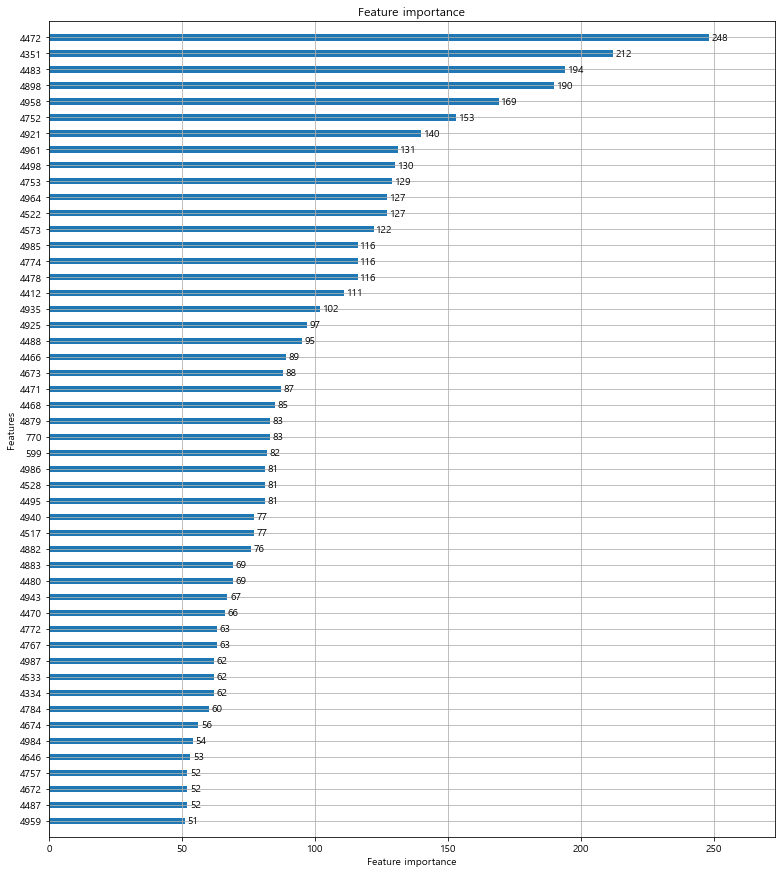

In [420]:
#feature importance 확인

from lightgbm import plot_importance
fig, ax = plt.subplots(figsize=(13,15))

plot_importance(models[0], ax=ax, max_num_features=50, height=0.4)  #model 0~4
plt.show()

In [247]:
pred_y_list = []
for model in models:
    pred_y = model.predict(final_test_x)   #각각의 모델에 test_X 넣어서 pred_y predict
    pred_y_list.append(pred_y.reshape(-1,1))  #k-fold에서 k가 5 이므로 동일 인덱스가 5개 들어있음
    
pred_ensemble = np.mean(pred_y_list, axis=0)  #5개에 대한 평균값 구함

print(pred_ensemble)
print()
print(pred_ensemble[:20])

[[0.95687331]
 [0.2667294 ]
 [0.54373907]
 ...
 [0.77217141]
 [0.90284971]
 [0.30756564]]

[[0.95687331]
 [0.2667294 ]
 [0.54373907]
 [0.82395447]
 [0.92548569]
 [0.8647743 ]
 [0.08097552]
 [0.07462078]
 [0.71045967]
 [0.36783845]
 [0.06511425]
 [0.23761556]
 [0.91154909]
 [0.05904609]
 [0.10824438]
 [0.21765269]
 [0.23809617]
 [0.35533661]
 [0.3198073 ]
 [0.19065336]]


In [235]:
#제출파일 load
sample_submission = pd.read_csv('./LG_data/sample_submission.csv')
sample_submission['problem'] = pred_ensemble.reshape(-1)
sample_submission.to_csv('./submission_data/dacon_submission_final_.csv', index=False)
